In [37]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import ase
import pandas as pd
import ase.io as aio

from easydict import EasyDict
from rdkit import Chem
from rdkit.Chem import rdDistGeom

from models.model import MolDiff
from models.bond_predictor import BondPredictor
from utils.sample import seperate_outputs
from utils.transforms import *
from utils.misc import *
from utils.reconstruct import *

from simgen.calculators import MaceSimilarityCalculator
from mace.calculators import mace_off
from ase.build import molecule
from pathlib import Path
from ase.optimize import FIRE

/home/rokas/miniconda3/envs/genesis/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  _Jd, _W3j_flat, _W3j_indices = torch.lo

In [2]:
df = pd.read_csv("./fda_approved_drugs.txt", sep="\t")
df = df.query("~smiles.isna()")
mols = [Chem.MolFromSmiles(smi) for smi in df.smiles]

In [3]:
penicillin_smiles = df.query("generic_name == 'Penicillin G'")["smiles"].values[0]
penicillin_mol = Chem.MolFromSmiles(penicillin_smiles)
patt = Chem.MolFromSmarts("O=C1CC2N1CCS2")

In [4]:
has_patt = [mol.HasSubstructMatch(patt) for mol in mols]

In [19]:
np.where(has_patt)
penicillin_analogues = [mols[i] for i in np.where(has_patt)[0]]

In [20]:
core_ids = [m.GetSubstructMatch(patt) for m in penicillin_analogues]

In [45]:
core_ids[1]

(8, 7, 9, 0, 6, 5, 2, 1)

In [35]:
def rdkit2ase(mol):
    assert mol.GetNumConformers() > 0
    pos = mol.GetConformer().GetPositions()
    symbols = [a.GetSymbol() for a in mol.GetAtoms()]
    return ase.Atoms(positions=pos, symbols=symbols)

In [36]:
embedding_params = rdDistGeom.ETKDGv3()
for i, m in enumerate(penicillin_analogues):
    m = Chem.AddHs(m)
    rdDistGeom.EmbedMolecule(m, embedding_params)
    penicillin_analogues[i] = m
penicillin_analogues_ase = [rdkit2ase(m) for m in penicillin_analogues]

In [38]:
calc = mace_off("medium", device="cuda", default_dtype="float32")
z_table = calc.z_table
mace_model = calc.models[0]

Using MACE-OFF23 MODEL for MACECalculator with /home/rokas/.cache/mace/MACE-OFF23_medium.model
Using float32 for MACECalculator, which is faster but less accurate. Recommended for MD. Use float64 for geometry optimization.


/home/rokas/miniconda3/envs/genesis/lib/python3.12/site-packages/mace/calculators/mace.py:135: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(f=model_path, map_loc

Default dtype float32 does not match model dtype float64, converting models to float32.


In [39]:
for m in penicillin_analogues_ase:
    m.calc = calc
    dyn = FIRE(m)
    dyn.run(fmax=0.5)
    m.calc = None

      Step     Time          Energy          fmax
FIRE:    0 18:17:23   -37392.363281        8.480704
FIRE:    1 18:17:23   -37393.824219        4.127608
FIRE:    2 18:17:24   -37393.980469        2.191226
FIRE:    3 18:17:24   -37394.121094        1.621688
FIRE:    4 18:17:24   -37394.203125        2.378781
FIRE:    5 18:17:25   -37394.296875        2.567383
FIRE:    6 18:17:25   -37394.429688        1.595678
FIRE:    7 18:17:25   -37394.531250        1.009205
FIRE:    8 18:17:26   -37394.566406        2.259657
FIRE:    9 18:17:27   -37394.578125        2.020422
FIRE:   10 18:17:27   -37394.597656        1.598790
FIRE:   11 18:17:27   -37394.621094        1.205442
FIRE:   12 18:17:27   -37394.640625        0.812372
FIRE:   13 18:17:27   -37394.656250        0.817965
FIRE:   14 18:17:27   -37394.667969        1.031454
FIRE:   15 18:17:27   -37394.679688        1.190737
FIRE:   16 18:17:27   -37394.695312        1.184151
FIRE:   17 18:17:27   -37394.718750        0.975584
FIRE:   18 18:

In [42]:
aio.write("penicillin_analogues.xyz", penicillin_analogues_ase)
np.save("penicillin_core_ids.npy", core_ids)

In [46]:
np.load("penicillin_core_ids.npy")

array([[ 4,  3,  2, 14,  5,  6, 10, 13],
       [ 8,  7,  9,  0,  6,  5,  2,  1],
       [ 8,  7,  9,  0,  6,  5,  2,  1],
       [ 8,  7,  9,  0,  6,  5,  2,  1],
       [15, 14, 13, 25, 16, 17, 21, 24],
       [ 8,  7,  9,  0,  6,  5,  2,  1],
       [ 8,  7,  9,  0,  6,  5,  2,  1],
       [ 8,  7,  9,  0,  6,  5,  2,  1],
       [ 8,  7,  9,  0,  6,  5,  2,  1],
       [ 8,  7,  9,  0,  6,  5,  2,  1],
       [ 8,  7,  9,  0,  6,  5,  2,  1],
       [ 8,  7,  9,  0,  6,  5,  2,  1],
       [ 8,  7,  9,  0,  6,  5,  2,  1],
       [ 8,  7,  9,  0,  6,  5,  2,  1],
       [ 8,  7,  9,  0,  6,  5,  2,  1],
       [ 8,  7,  9,  0,  6,  5,  2,  1],
       [ 8,  7,  9,  0,  6,  5,  2,  1],
       [ 8,  7,  9,  0,  6,  5,  2,  1],
       [ 8,  7,  9,  0,  6,  5,  2,  1],
       [ 8,  7,  9,  0,  6,  5,  2,  1],
       [ 4,  3,  2, 22,  5,  6, 18, 21],
       [ 3,  2,  1,  0,  4,  5,  9, 17],
       [ 8,  7,  9,  0,  6,  5,  2,  1]])

In [60]:
ckpt = torch.load("./ckpt/MolDiff.pt", map_location="cuda")

/tmp/ipykernel_1261/3363570379.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("./ckpt/MolDiff.pt", map_location="cuda")


In [61]:
train_config = ckpt["config"]
featurizer = FeaturizeMol(train_config.chem.atomic_numbers, train_config.chem.mol_bond_types,
                            use_mask_node=train_config.transform.use_mask_node,
                            use_mask_edge=train_config.transform.use_mask_edge,)

In [62]:
model = MolDiff(
    config=train_config.model,
    num_node_types=featurizer.num_node_types,
    num_edge_types=featurizer.num_edge_types,
).to("cuda")
model.load_state_dict(ckpt["model"])
model.eval()

MolDiff(
  (pos_transition): ContigousTransition()
  (node_transition): GeneralCategoricalTransition()
  (edge_transition): GeneralCategoricalTransition()
  (node_embedder): Linear(in_features=8, out_features=246, bias=False)
  (edge_embedder): Linear(in_features=6, out_features=54, bias=False)
  (time_emb): Sequential(
    (0): GaussianSmearing()
  )
  (denoiser): NodeEdgeNet(
    (distance_expansion): GaussianSmearing()
    (node_blocks_with_edge): ModuleList(
      (0-5): 6 x NodeBlock(
        (node_net): MLP(
          (net): Sequential(
            (0): Linear(in_features=256, out_features=256, bias=True)
            (1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
            (2): ReLU()
            (3): Linear(in_features=256, out_features=256, bias=True)
          )
        )
        (edge_net): MLP(
          (net): Sequential(
            (0): Linear(in_features=64, out_features=256, bias=True)
            (1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)


In [67]:
ase_mol.calc = calc
dyn = FIRE(ase_mol)
dyn.run(fmax=0.05)

      Step     Time          Energy          fmax
FIRE:    0 15:37:34   -38907.175781        9.209658
FIRE:    1 15:37:34   -38908.531250        4.414062
FIRE:    2 15:37:34   -38908.707031        2.663705
FIRE:    3 15:37:35   -38908.871094        1.831516
FIRE:    4 15:37:35   -38908.980469        2.728563
FIRE:    5 15:37:35   -38909.109375        2.626109
FIRE:    6 15:37:35   -38909.269531        1.655919
FIRE:    7 15:37:35   -38909.375000        1.211529
FIRE:    8 15:37:35   -38909.406250        2.302288
FIRE:    9 15:37:36   -38909.421875        2.100570
FIRE:   10 15:37:36   -38909.445312        1.735562
FIRE:   11 15:37:36   -38909.468750        1.285346
FIRE:   12 15:37:36   -38909.492188        1.235374
FIRE:   13 15:37:36   -38909.511719        1.208689
FIRE:   14 15:37:36   -38909.527344        1.203031
FIRE:   15 15:37:36   -38909.546875        1.344923
FIRE:   16 15:37:36   -38909.570312        1.333771
FIRE:   17 15:37:36   -38909.601562        1.136294
FIRE:   18 15:

True

In [68]:
aio.write("penicillin_opt.xyz", ase_mol)

In [78]:
ase_mol = ase_mol[ase_mol.numbers != 1][core_ids]

In [79]:
from ase.visualize import view

In [80]:
view(ase_mol)

<Popen: returncode: None args: ['/home/rokas/miniconda3/envs/genesis/bin/pyt...>

In [ ]:
ref_data_path = Path("~/Programming/data/qm9_no_hydrogens_small.xyz").expanduser()
ref_data = aio.read(ref_data_path, index=":64")

In [143]:
element_sigma_array = np.ones_like(z_table.zs, dtype=np.float32)*0.25
element_sigma_array[z_table.z_to_index(6)] = 0.25
sim_calc = MaceSimilarityCalculator(
    mace_model,
    reference_data=[ase_mol],
    device="cuda",
    alpha=0,
    element_sigma_array=element_sigma_array,
    max_norm=None,
)

In [144]:
batch_holder = make_data_placeholder(n_graphs=12, device="cuda", max_size=12)
batch_node, halfedge_index, batch_halfedge = (
    batch_holder["batch_node"],
    batch_holder["halfedge_index"],
    batch_holder["batch_halfedge"],
)
outputs = model.sample(
    n_graphs=12,
    batch_node=batch_node,
    halfedge_index=halfedge_index,
    batch_halfedge=batch_halfedge,
    bond_predictor=bond_predictor,
    guidance=("simgen", 0.6),
    featurizer=featurizer,
    simgen_calc=sim_calc,
)

100%|██████████| 1000/1000 [04:18<00:00,  3.87it/s]


In [145]:
outputs = {key:[v.cpu().numpy() for v in value] for key, value in outputs.items()}

In [146]:
batch_node, halfedge_index, batch_halfedge = batch_node.cpu().numpy(), halfedge_index.cpu().numpy(), batch_halfedge.cpu().numpy()
output_list = seperate_outputs(outputs, 12, batch_node, halfedge_index, batch_halfedge)

In [140]:
def traj_to_ase(out, featurizer):
    traj = []
    nodes_to_elements = featurizer.nodetype_to_ele.copy()
    nodes_to_elements[7] = 6
    for nodes, positions, _ in zip(*out):
        numbers = [nodes_to_elements[n] for n in np.argmax(nodes, axis=1)]
        atoms = ase.Atoms(numbers, positions=positions)
        traj.append(atoms)
    return traj

In [147]:
last_frames = [traj_to_ase(out["traj"], featurizer)[-1] for out in output_list]
output_mol = output_list[9]
traj_info = [featurizer.decode_output(
                        pred_node=output_mol['traj'][0][t],
                        pred_pos=output_mol['traj'][1][t],
                        pred_halfedge=output_mol['traj'][2][t],
                        halfedge_index=output_mol['halfedge_index'],
                    ) for t in range(len(output_mol['traj'][0]))]

In [148]:
aio.write("./moldiff_traj.xyz", last_frames)

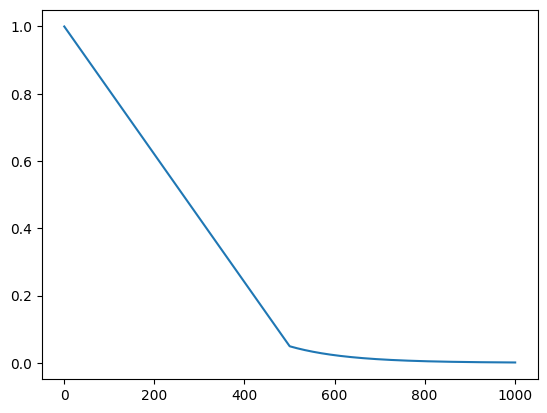

In [128]:
num_steps = 1002
sigmas = (
    torch.concatenate(
        [
            torch.linspace(1, 0.05, num_steps // 2),
            torch.logspace(-1.31, -3, num_steps // 2),
        ]
    )
)
plt.plot(sigmas)

In [ ]:
test_traj = traj_to_ase(output_mol["traj"], featurizer)
forces = []
energy = []
for i, atoms in enumerate(test_traj[::2]):
    atoms.calc = sim_calc
    atoms.info["calculation_type"] = "similarity"
    atoms.info["time"] = sigmas[i].numpy()
    print(atoms.get_potential_energy())
    forces.append(atoms.get_forces())
    energy.append(atoms.get_potential_energy())

In [ ]:
avg_force_mags = [np.linalg.norm(sim_calc._clip_grad_norm(f, np.sqrt(3)),axis=-1).mean(axis=0)*1e-1 for f in forces]
avg_force_mags = [x if x < 10 else 10 for x in avg_force_mags ]

In [ ]:
output_list[0]["traj"][1].shape
diffs = np.diff(output_list[0]["traj"][1], axis=0)
average_diff_mag = np.mean(np.linalg.norm(diffs, axis=-1), axis=1)

In [ ]:
plt.plot(average_diff_mag)
x = np.linspace(0,1000,len(avg_force_mags))
plt.plot(x,avg_force_mags)

In [1]:
import pathlib
import rdkit.Chem as Chem
import numpy as np
import yaml
from rdkit.Chem import rdmolops
import matplotlib.pyplot as plt

In [3]:
results_path = pathlib.Path("./results")
out_mols = {}
out_smiles = {}
out_logdens = {}
# iterate over folders in results_path
for subfolder in results_path.iterdir():
    if subfolder.stem == "test":
        exp_num = 50
        continue
    else:
        exp_num = int(subfolder.stem.split("_")[-1])
    with open(subfolder / "SMILES.txt") as f:
        mols = [Chem.MolFromSmiles(line.strip()) for line in f]
        smiles = [line.strip() for line in f]
        out_mols[exp_num] = mols
        out_smiles[exp_num] = smiles
    arr = np.load(subfolder / "log_densities.npy")
    out_logdens[exp_num] = arr

In [4]:
configs = {}
for config in pathlib.Path("./screen_configs_inverse_summation").iterdir():
    config_num = int(config.stem.split("_")[-1])
    configs[config_num] = yaml.safe_load(config.read_text())
# with open("./test_config.yaml") as f:
#     configs[50] = yaml.safe_load(f)

In [5]:
fragmented_fracs = np.zeros(len(out_mols))
for k, mol_list in out_mols.items():
    num_frags = np.array([len(rdmolops.GetMolFrags(mol, asMols=True)) for mol in mol_list])
    fragmented_fracs[k] = (num_frags > 1).mean()
fragmented_fracs

array([0.01015625, 0.6519573 , 0.14143568, 0.00781805, 0.82382311,
       0.00781805, 0.20898716, 0.42075338, 0.82007168, 0.05234375,
       0.01328125, 0.11024182, 0.03198294, 0.83776023, 0.1171875 ,
       0.04267425, 0.26495726, 0.00426439, 0.91874555, 0.43345196,
       0.02629709, 0.63857143, 0.01918977, 0.03411514, 0.046875  ,
       0.79742305, 0.11015625, 0.00390625, 0.47829181, 0.0021322 ,
       0.83797288, 0.06041222, 0.9800995 , 0.128125  , 0.60243553,
       0.87723055, 0.00923952, 0.01350391, 0.4832978 , 0.78463747,
       0.10803127, 0.00234375, 0.94519573, 0.79985755, 0.08125   ,
       0.06171875, 0.0046875 , 0.134375  , 0.02062589, 0.02418208])

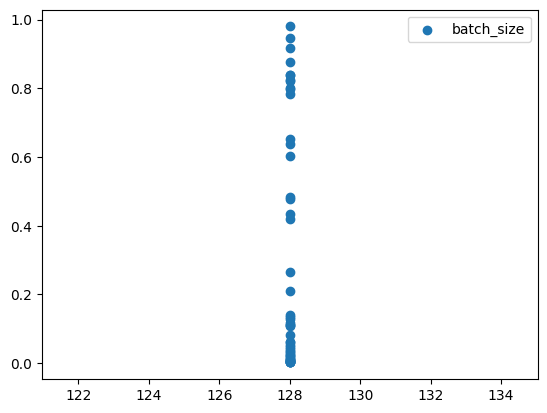

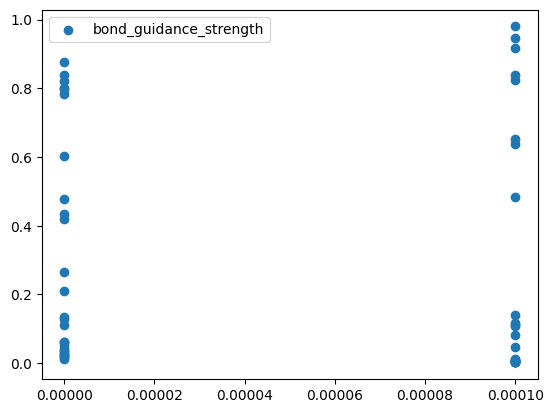

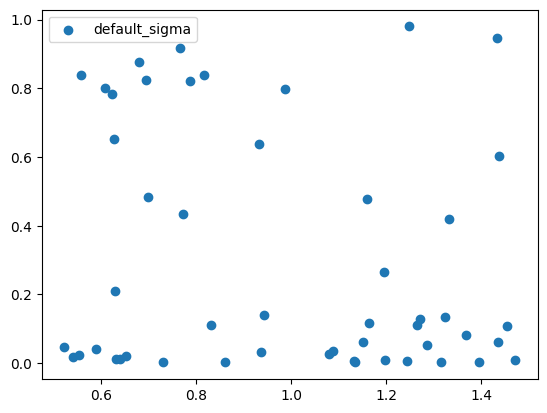

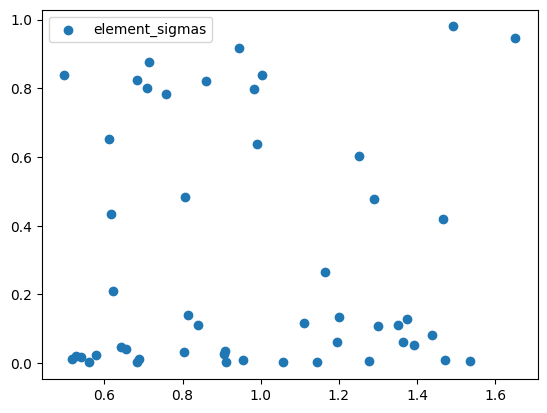

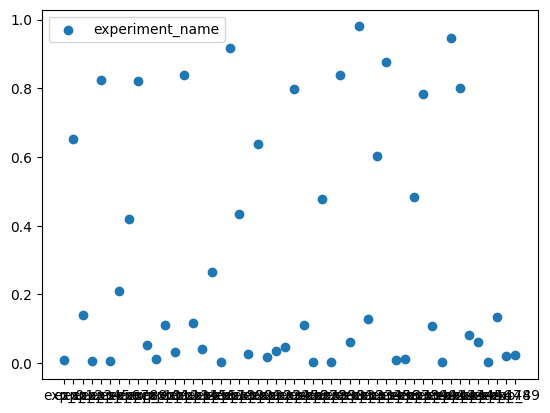

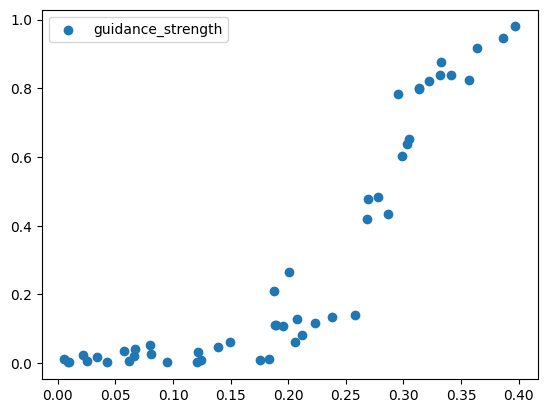

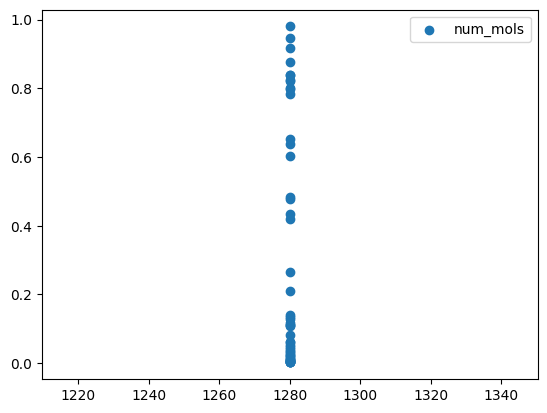

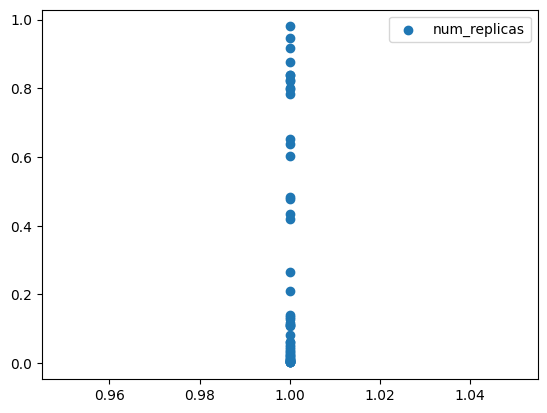

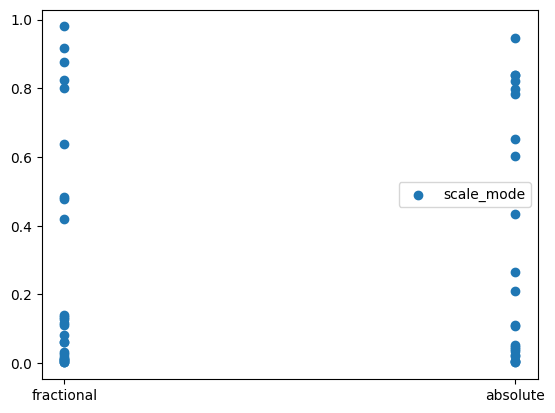

In [6]:
# iterate over screened params and plot param value vs fragmented fraction
config_example = configs[0]
for param in config_example.keys():
    if param != "element_sigmas":
        xs = [configs[i][param] for i in range(len(configs))]
    else:
        xs = [configs[i][param][7] for i in range(len(configs))]
    plt.scatter(xs, fragmented_fracs, label=param)
    plt.legend()
    plt.show()

In [7]:
penicillin_core_mol = Chem.MolFromSmiles("O=C1CC2N1CCS2")
lactam_patt = Chem.MolFromSmarts("O=C1NCC1")
thio_ring_patt = Chem.MolFromSmarts("[#6]1[#16][#6][#6][#6]1")
fp = Chem.RDKFingerprint(penicillin_core_mol)

In [8]:
fps = {k: [Chem.RDKFingerprint(mol) for mol in mols] for k, mols in out_mols.items()}

In [9]:
sims = {}
for i, fps in fps.items():
    sim_holder = np.array([Chem.DataStructs.FingerprintSimilarity(fp, f) for f in fps])
    sims[i] = sim_holder

In [10]:
max_sims = [np.max(sims[i]) for i in range(len(sims))]
mean_sims = [np.median(sims[i]) for i in range(len(sims))]
top_sims = [np.mean(np.sort(sims[i])[-5:]) for i in range(len(sims))]
mean_logdens = [np.mean(out_logdens[i]) for i in range(len(out_logdens))]

In [11]:
has_lactam = {k: [mol.HasSubstructMatch(lactam_patt) for mol in mols] for k, mols in out_mols.items()}
has_thio_ring = {k: [mol.HasSubstructMatch(thio_ring_patt) for mol in mols] for k, mols in out_mols.items()}
has_both = {k: [mol.HasSubstructMatch(lactam_patt) and mol.HasSubstructMatch(thio_ring_patt) for mol in mols] for k, mols in out_mols.items()}

In [12]:
num_lactams = np.array([np.sum(has_lactam[i]) for i in range(len(has_lactam))])
num_thio_rings = np.array([np.sum(has_thio_ring[i]) for i in range(len(has_thio_ring))])
num_both = np.array([np.sum(has_both[i]) for i in range(len(has_both))])
num_lactams, np.argsort(num_lactams)

(array([0, 1, 0, 1, 0, 1, 1, 1, 0, 3, 1, 0, 0, 0, 1, 2, 1, 1, 0, 0, 1, 0,
        1, 2, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 2, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 3, 0]),
 array([ 0,  2,  4,  8, 12, 13, 11, 19, 24, 25, 26, 27, 31, 21, 18, 32, 40,
        41, 49, 47, 43, 46, 45, 44, 39, 35, 42, 38, 33, 22, 17,  1,  7,  6,
         5, 30, 16, 20, 28, 29, 14, 10, 36,  3, 34, 37, 15, 23,  9, 48]))

batch_size is constant


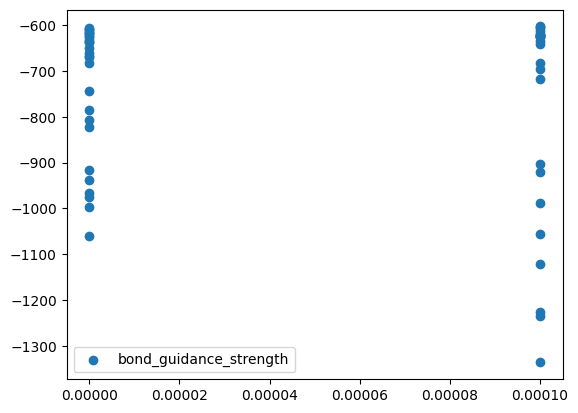

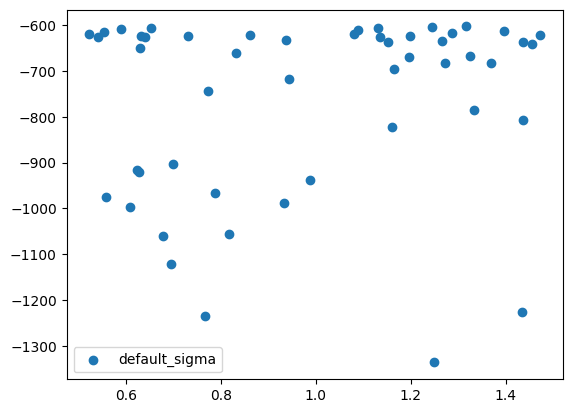

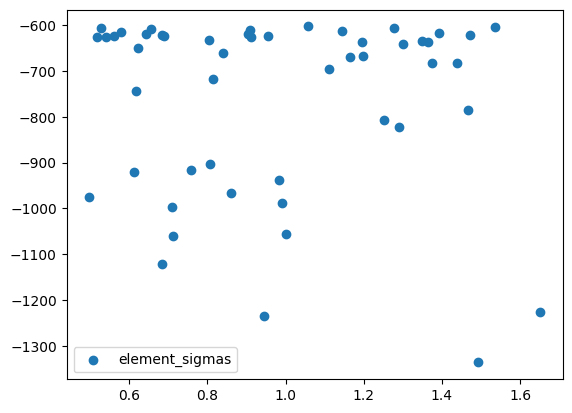

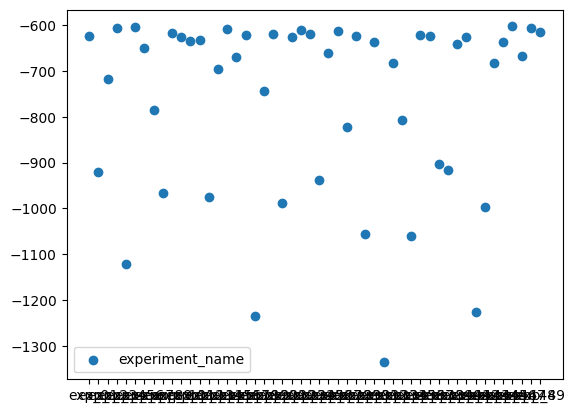

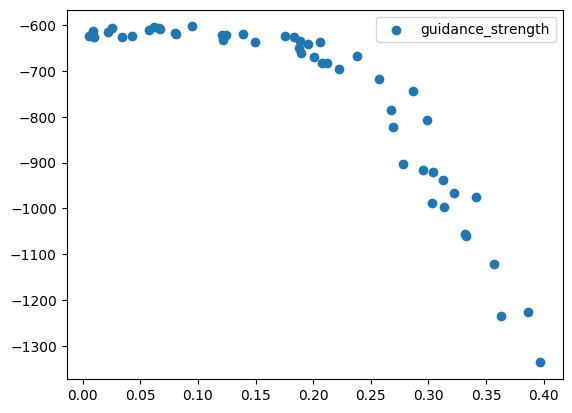

num_mols is constant
num_replicas is constant


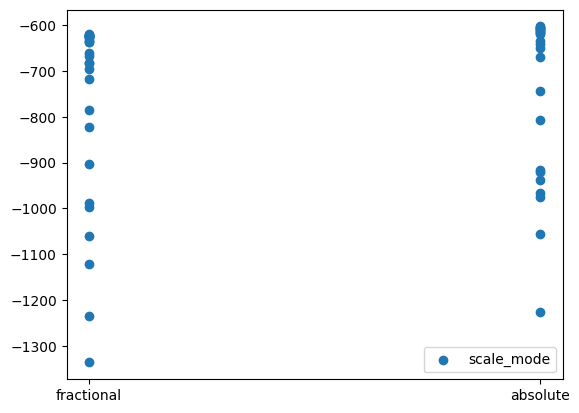

In [13]:
# iterate over screened params and plot param value vs fragmented fraction
config_example = configs[0]
for param in config_example.keys():
    if param != "element_sigmas":
        xs = [configs[i][param] for i in range(len(configs))]
    else:
        xs = [configs[i][param][7] for i in range(len(configs))]
    if len(np.unique(xs)) > 1:
        plt.scatter(xs, mean_logdens, label=param)
        plt.legend()
        plt.show()
    else:
        print(f"{param} is constant")

In [24]:
np.argsort(mean_logdens)

array([32, 18, 42,  4, 37, 41, 21, 35, 43, 30, 13, 38, 22, 27,  8,  7, 29,
       28,  3, 49,  2, 47, 25, 20, 14, 44, 33, 36, 45, 34,  0, 10, 17, 12,
       26, 31, 39,  5,  1, 23, 15,  9, 48, 19, 24, 46, 40, 11, 16,  6])

In [50]:
np.argsort(out_logdens[40])[-10:]

array([ 239,  648,   44,  469,  105,   55, 1080, 1377,  690,  819])

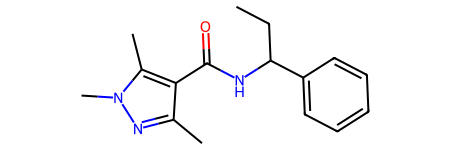

In [54]:
out_mols[40][1080]

In [79]:
np.where(has_lactam[6])

(array([  52,   69,   95,  164,  240,  284,  379,  559,  657,  798,  994,
        1015, 1099, 1159, 1334]),)

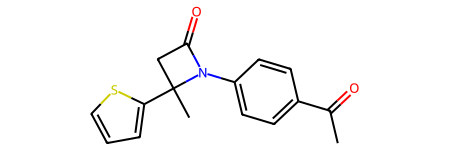

In [87]:
out_mols[6][559]